<!-- BEGIN QUESTION -->

## Introduction

Using https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot to predict housing prices


In [4]:
import pandas as pd
#data = pd.read_csv("./utility/melb_data.csv")



The structured data table, created by Tony Pino, is a sample of sold real estate in Melbourne, Australia from July 1, 2017 to September 9, 2017. The information was taken from the website Domain.com.au. There are 21 features total which consists of numerical features such as 'price' that the real estate sold at(float), nominal features like the 'Address' of the real estate (string), and ordinal features like the 'Type' of real estate the example is(string). Some of the other types of values for the features are ints and dates. There are 13580 examples. I would like to explore the relationship between the price sold and most other features, most likely number of bedrooms, suburb, rooms, buildingArea and yearbuilt.


In [2]:
#!pip install ydata-profiling
#from pandas_profiling import ProfileReport

#ProfileReport(data)


The domain of this dataset is real estates. Since I am using price as the target variable, which is continous, I should use a regression type of prediction. From the profile report, I found that there is 8 categorical variables types and 13 numeric. There is alos 4.6% missing cells out of all the cells, which is high. Going further I will need to look into where the missing cells are and munipulate the dataset before modeling. 

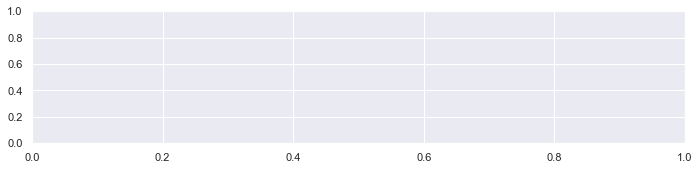

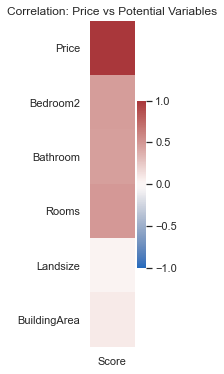

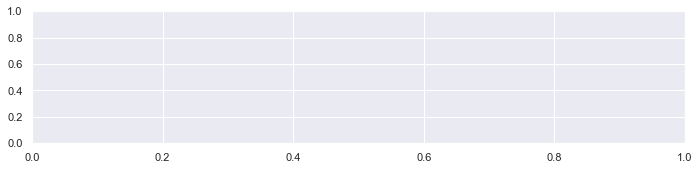

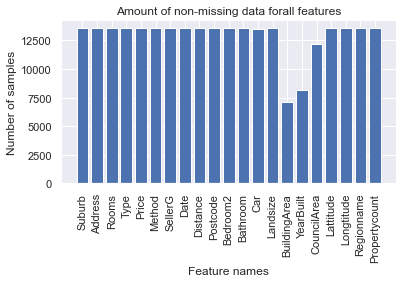

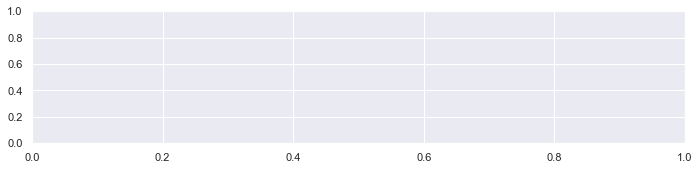

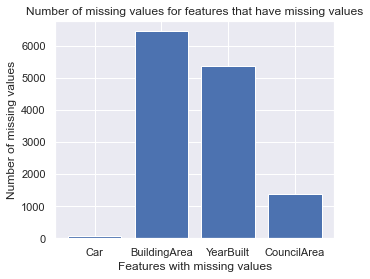

In [ ]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

plt.subplot(311)
t = ["Price", "Bedroom2","Bathroom","Rooms","Landsize","BuildingArea"]
ride = data[t]
m = ride.corr()['Price']
m = np.array(m)
plt.figure(figsize=(1,6))
sns.heatmap(m[:, None], cmap=sns.cm.vlag, vmin=-1)
plt.xticks([0.5], ['Score'], rotation=0)
plt.yticks(np.arange(m.shape[0]) + 0.5, ["Price", "Bedroom2","Bathroom","Rooms","Landsize","BuildingArea"], rotation=0)
plt.title('Correlation: Price vs Potential Variables')
plt.show()


plt.subplot(312)
missing = data.isna().sum()
plt.figure(figsize = (6,3))
plt.bar(data.columns,len(data) - missing)

plt.xticks(rotation = 90)
plt.title("Amount of non-missing data forall features")
plt.ylabel("Number of samples")
plt.xlabel("Feature names")
plt.show()

plt.subplot(313)
plt.figure(figsize = (5,4))
p = ['Car', 'BuildingArea', 'YearBuilt','CouncilArea']
plt.bar(data[p].columns,missing[p]) 
plt.title("Number of missing values for features that have missing values")
plt.ylabel("Number of missing values")
plt.xlabel("Features with missing values")
plt.show()

 Using pandas data profile report, I noticed that price and rooms, price and bedrooms, price and bedroom2 have the highest positive correlation, so does BuildingArea. However Building Area has 6450 missing values which is 47.5% the total samples and it is listed as skewed, because of this it will be more accurate to not use BuildingArea in predicting price. I had not realized that there was so much missing data, especially for YearBuilt, BuildingArea, and ConcilArea, when I eyeballed the data originally. Its also worth noting that Landsize has 1939 zeros, which are not considered missing data they were purposely zeros. This seems suprising because its seems impossible for landsize to be zero when referring to real estate. However after investigating the dataset, I found that a landsize of zero is primarly for units, townhouses, duplex meaning that they would not have there own yards. 

### Training the data


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

X = data.loc[:, data.columns !='Price']
y = data['Price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

kf = KFold(10, shuffle=True, random_state=None)

80/20 split is considered good practice because it utilizes enoough data (80% of the set) to create a accurate model. While still having enough samples to accurately test the model to make sure it is just as accurate on training data as it is on new data that the model has not seen. If the dataset is large then its important to allocate a higher percentage of the total dataset to training so that it can gather a strong model. This could be 90/10 split. However if the dataset is relatively small then you want to allocate a higher percentage of the dataset to testing like a 70/30. Cross validation helps to compare and choose the best model for the given dataset and problem you are solving. It ensures model robustness by testing on validation data that the model has not seen yet. Data snooping refers to artifically results found when analysising data without having a strong understanding of data before hand. One way to avoid this is to use data profiling to understand the relationships between the data and using that to create a hypothesis before creating models.

## Prepping for Model Testing


Before we can preform regressions on the data we will need to clean it. First removing BuildingArea and yearbuilt because it has almost half of the values missing. Also, Address and date need to be removed because both features have so many unique values that running models on the dataset could lead to overfitting. 

In [ ]:
for data in [X_train, X_test]:
    data.drop(['BuildingArea','Address', 'Date'], axis=1, inplace=True)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
np.random.seed(42)

cat_cols = ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=True))
])




num_cols = ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

# your code here 
num_transformer = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])




### Perform Linear Regression



In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])



pipeline_LF = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',LinearRegression())])

pipeline_LF.fit(X_train,y_train)

y_pred = pipeline_LF.predict(X_test)

linear_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
linear_r_2 = r2_score(y_test, y_pred)

print(f'RMSE: {linear_rmse:0.0f}')
print(f'R2: {linear_r_2:0.3f}')


RMSE: 350720
R2: 0.702


R^2 is a good measure to use because it ranges from 0 to 1 whereas RMSE techinically can range from 0 to infinity. Having a set range better informs the user of the strength of the model based on how close r^2 is to 1. Also since r^2 is a measurement of the strength of the relationship between variables and the model, it gives a more accurate answer to what we are looking for in regression.

### Perform K-Nearest Neighbors Regression



Using GridSeach for CV even though it takes longer,  there is a  chance that randomsearch will pick random values that are all in the same location and get inaccurate results. Because GridSearchCV preforms Cv i will not have to utilize Kfolds. I chose variables 7,9,11 for n_neighbors because if I used a small k value like 1 theres a chance of being sensitive to a lot of noise and overfitting. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

pipeline_kNN = Pipeline(steps=[('preprocessor', preprocessor),
                               ('knn', KNeighborsRegressor())])

param_grid = {'knn__n_neighbors': [7,9,11]}

kNN_grid_search = GridSearchCV(pipeline_kNN, param_grid=param_grid)

kNN_grid_search.fit(X_train, y_train)

print(f'Best Accuracy: {kNN_random_search.best_score_}')
print(f'Best Parameters: {kNN_random_search.best_params_}')


Best Accuracy: 0.7224376401060939
Best Parameters: {'knn__n_neighbors': 11}


In [ ]:

y_pred = kNN_grid_search.predict(X_test)

kNN_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
kNN_r_2 = r2_score(y_test, y_pred)

print(f'RMSE: {kNN_rmse:0.0f}')
print(f'R2: {kNN_r_2:0.3f}')

RMSE: 326600
R2: 0.742


Linear Regression predicts countinous output variables based on the linear relationship between the given x and y variable(s). Whereas K-NN groups data into K groups based on distance of each point and predicts which group new data will be placed in. For KNN regression you will need to test what k creates the most accurate results, as done above. Furthermore the process of predicting is different, in K-NN you calculate the distance between new data points and all the groups to determine which group the new data will be placed in. Then calculate the predicted value of the new data based on its k-nn group

### Perform Decision Tree Regression 


In [ ]:
from sklearn.tree import DecisionTreeRegressor


pipeline_DT = Pipeline(steps=[('preprocessor', preprocessor),
                               ('dt', DecisionTreeRegressor())])

param_grid = {'dt__max_depth': range(1, 21)}

DT_grid_search = GridSearchCV(pipeline_DT, param_grid=param_grid)

DT_grid_search.fit(X_train, y_train)

print(f'Best Accuracy: {DT_random_search.best_score_}')
print(f'Best Parameters: {DT_random_search.best_params_}')

Best Accuracy: 0.6494532965963635
Best Parameters: {'dt__max_depth': 9}


In [ ]:

y_pred = DT_grid_search.predict(X_test)

DT_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
DT_r_2 = r2_score(y_test, y_pred)

print(f'RMSE: {DT_rmse:0.0f}')
print(f'R2: {DT_r_2:0.3f}')

RMSE: 364802
R2: 0.677


 Decision Tree was much faster than both Linear Regression and KNN. However it was less accurate then both of them.

### Perform Random Forest Regression


In [ ]:

from sklearn.ensemble import RandomForestRegressor


pipeline_RF = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor())])


param_dist = {'rf__n_estimators': [1,5,10]}

RF_grid_search = GridSearchCV(pipeline_RF, param_grid=param_dist)

RF_grid_search.fit(X_train, y_train)

print(f'Best Accuracy: {RF_grid_search.best_score_}')
print(f'Best Parameters: {RF_grid_search.best_params_}')

Best Accuracy: 0.7628977579482144
Best Parameters: {'rf__n_estimators': 10}


In [ ]:

RF_y_pred = RF_grid_search.predict(X_test)

RF_rmse = np.sqrt(mean_squared_error(y_test, RF_y_pred))
RF_r_2 = r2_score(y_test, RF_y_pred)

print(f'RMSE: {RF_rmse:0.0f}')
print(f'R2: {RF_r_2:0.3f}')

RMSE: 296898
R2: 0.786


Random Forest tree is less likely to overfit that Decision Tree because its trained on random data so its not going to be as easily influenced by noise as Decision Tree's will be.

### Feature Selection

In [ ]:
def get_RF_mask(X_in,y_in, model_in):
    
    importance = None
    mask = None

    model_in.fit(X_in, y_in)
    
    importance = model_in.feature_importances_
    med = np.median(importance)
    mask = importance > med
    
    
    return mask

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_scaled_train = preprocessor.fit_transform(X_train)
X_scaled_test = preprocessor.transform(X_test)

model = RandomForestClassifier(n_estimators = 100, random_state = 42)

rf_mask = get_RF_mask(X_scaled_train, y_train, model)

X_train_selected = X_scaled_train[:,rf_mask]

print(f'     All Features: {X_scaled_train.shape}')
print(f'Selected Features: {X_train_selected.shape}')


X_test_selected = X_scaled_test[:,rf_mask]
print(f'     All Features: {X_scaled_test.shape}')
print(f'Selected Features: {X_test_selected.shape}')



     All Features: (10864, 615)
Selected Features: (10864, 307)
     All Features: (2716, 615)
Selected Features: (2716, 307)


Model based Feature selection looks at all features in the dataset and keeps the features that are relevent while discarding the features that create noise. This can be done using  random forest classifier, which take the data and calculates the importance score for each feature - as shown above. Since we already have a model for Random forest, we dont have to recreate one. Random forest classifiers are more efficient and faster on larger sets of data that recursive feature elimination.

### Feature Extraction


In [ ]:
for dataset in [X_train, X_test]:
    dataset['Bed_bath'] = dataset['Bedroom2'] + dataset['Bathroom']
    dataset.drop(['Rooms','Bedroom2','Bathroom'], axis=1, inplace=True)


In [ ]:
num_cols = [ 'Distance', 'Postcode', 'Car', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']


num_transformer = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])


I noticed that in some data points the value for the Rooms variable was less than the sum of Bedroom2 and Bathroom which cannot be possible. Therefore rooms is most likely not accuate. So I created a new feature called Bed_Bath which is the sum of bedroom and bathrooms of each propety. I then deleted rooms, bedroom2, and bathroom. Also had to recall preprocessor, num_transformer, and change num_cols to get ride of the dropped columns. 

## Feature Engineered Models


### Perform Linear Regression


In [ ]:

pipeline_LF = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',LinearRegression())])

pipeline_LF.fit(X_train,y_train)

y_pred = pipeline_LF.predict(X_test)

linear_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
linear_r_2 = r2_score(y_test, y_pred)

print(f'RMSE: {linear_rmse:0.0f}')
print(f'R2: {linear_r_2:0.3f}')

RMSE: 400379
R2: 0.612


### Perform K-Nearest Neighbors Regression


In [ ]:
pipeline_kNN = Pipeline(steps=[('preprocessor', preprocessor),
                               ('knn', KNeighborsRegressor())])

param_grid = {'knn__n_neighbors': [7,9,11]}

kNN_grid_search = GridSearchCV(pipeline_kNN, param_grid=param_grid)

kNN_grid_search.fit(X_train, y_train)

y_pred = kNN_grid_search.predict(X_test)

kNN_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
EkNN_r_2 = r2_score(y_test, y_pred)

print(f'RMSE: {kNN_rmse:0.0f}')
print(f'R2: {EkNN_r_2:0.3f}')

RMSE: 370490
R2: 0.667


### Perform Decision Tree Regression 

In [ ]:

pipeline_DT = Pipeline(steps=[('preprocessor', preprocessor),
                               ('dt', DecisionTreeRegressor())])

param_grid = {'dt__max_depth': range(1, 21)}

DT_grid_search = GridSearchCV(pipeline_DT, param_grid=param_grid)

DT_grid_search.fit(X_train, y_train)
y_pred = DT_grid_search.predict(X_test)

DT_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
EDT_r_2 = r2_score(y_test, y_pred)

print(f'RMSE: {DT_rmse:0.0f}')
print(f'R2: {EDT_r_2:0.3f}')

RMSE: 432082
R2: 0.548


### Perform Random Forest Regression


In [ ]:
pipeline_RF = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor())])

param_dist = {'rf__n_estimators': [1,5,10]}

RF_grid_search = GridSearchCV(pipeline_RF, param_grid=param_dist)

RF_grid_search.fit(X_train, y_train)

RF_y_pred = RF_grid_search.predict(X_test)

RF_rmse = np.sqrt(mean_squared_error(y_test, RF_y_pred))
ERF_r_2 = r2_score(y_test, RF_y_pred)
print(f'RMSE: {RF_rmse:0.0f}')
print(f'R2: {ERF_r_2:0.3f}')

RMSE: 331462
R2: 0.734


## Compare Models

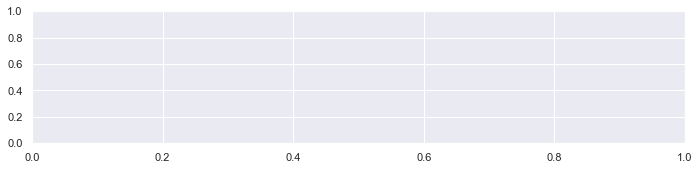

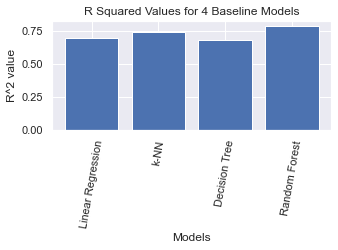

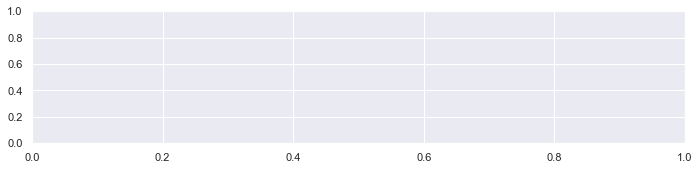

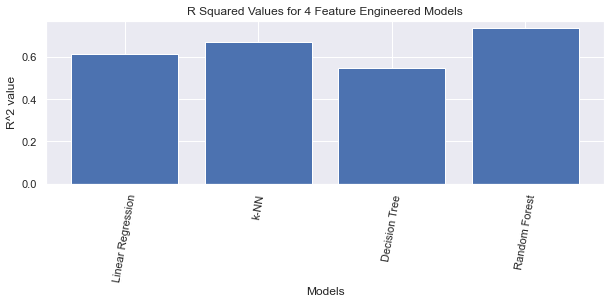

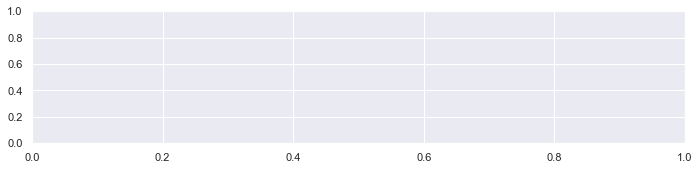

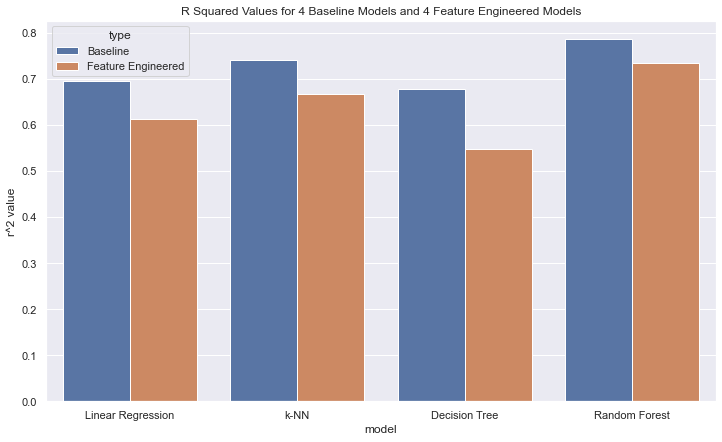

In [ ]:
plt.subplot(311)
plt.figure(figsize = (5,2))
plt.bar(['Linear Regression', 'k-NN','Decision Tree','Random Forest'],[r_2, kNN_r_2, DT_r_2,RF_r_2])
plt.title("R Squared Values for 4 Baseline Models")
plt.xticks(rotation = 80)
plt.ylabel('R^2 value')
plt.xlabel('Models')
plt.show()

plt.subplot(312)
plt.figure(figsize = (10,3))
plt.bar(['Linear Regression', 'k-NN','Decision Tree','Random Forest'], [linear_r_2, EkNN_r_2, EDT_r_2, ERF_r_2])
plt.title("R Squared Values for 4 Feature Engineered Models")
plt.xticks(rotation = 80)
plt.ylabel('R^2 value')
plt.xlabel('Models')
plt.show()

plt.subplot(313)





data = {'r^2 value': [r_2, kNN_r_2, DT_r_2,RF_r_2,linear_r_2, EkNN_r_2, EDT_r_2, ERF_r_2],
         'model' : ['Linear Regression', 'k-NN','Decision Tree','Random Forest','Linear Regression', 'k-NN','Decision Tree','Random Forest'],
       'type': ['Baseline','Baseline','Baseline','Baseline','Feature Engineered','Feature Engineered','Feature Engineered','Feature Engineered']} 
df = pd.DataFrame(data)
plt.figure(figsize = (12,7))
plt.title("R Squared Values for 4 Baseline Models and 4 Feature Engineered Models")

sns.barplot(data=df, x="model", y="r^2 value", hue="type")
plt.show()

Looking at the baseline models, Random Forest regression had the highest R^squared value, although it had the highest asymptotic cost. Decision tree had the best asymptotic time complexity as testing the model requires simply triversing done the tree. For each of the models, The feature engineered values were lower than their respective baseline values this could be because in the feature selection preprocessing the data caused data snooping when the training and validation folds were preprocessed together. The rankings for highest r value was the same in baseline as feature engineered with random forest having the highest value. Therefore going forward random 